In [1]:
%matplotlib notebook
from sklearn import datasets, model_selection
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.legend_handler import HandlerLine2D
from utils import *

<IPython.core.display.Javascript object>


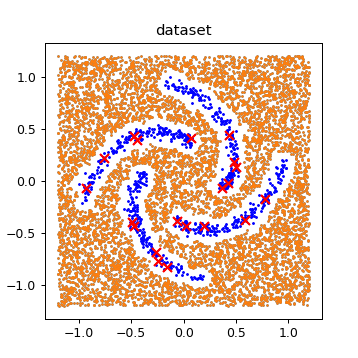

In [2]:
################Choose dataset #################
X,y = spiral(200)
# X,y = datasets.make_moons(n_samples=1000,noise=0.01)
# X = np.concatenate([np.random.multivariate_normal([-1.5,0],np.eye(2)/10,1000),np.random.multivariate_normal([+1.5,0],np.eye(2)/10,1000)])
# y = np.concatenate([np.ones(1000),np.zeros(1000)])
nb_labels = 5
################################################
ids = np.random.permutation(y.shape[0])
X=X[ids]
y=y[ids]
txs=[]
tys=[]
for j in range(int(np.max(y))+1):
    txs.append(X[y==j][:nb_labels])
    tys.append(y[y==j][:nb_labels])
X_lab = np.concatenate(txs,axis=0)
y_lab = np.concatenate(tys,axis=0)
f,ax = plt.subplots()
f.set_size_inches(4,4)

scatter_dataset(ax,X,np.zeros_like(y),s=1,c='b')
scatter_dataset(ax,X_lab,y_lab,s=50,marker='x',c='r')
ax.set_title('dataset')
# return X,y, X_lab, Y_lab
ex = gen_examples(10000,X)
scatter_dataset(ax,ex,np.zeros(ex.shape[0]),s=1)

In [22]:
def plot_gan(f,ax):
    scale = 1.5
    xmin = -scale
    xmax = scale
    ymin = -scale
    ymax = scale
    xx, yy = make_meshgrid(xmin,xmax,ymin,ymax, h=0.05)
    ax[0].clear()
#     X_gen = ssgan.generate_random_samples(100)
    plot_contours(ax[0], ssgan.predict_fake, xx,yy,cmap=plt.cm.coolwarm, alpha=0.6)
    
    scatter_dataset(ax[0],X,np.zeros_like(y),s=0.5,c=(0.1,0.1,0.1))
    scatter_dataset(ax[0],X_lab,y_lab,s=5,marker='x')
    ax[0].set_title('classification')
    ax[0].set_xlim(xmin,xmax)
    ax[0].set_ylim(ymin,ymax)
    
    ax[1].clear()
#     X_gen=gen_examples(100, X)
    X_gen = ssgan.generate_random_samples(100)
#     X_gen = gen_examples(100)
    plot_contours(ax[1], ssgan.discriminate, xx,yy,cmap=plt.cm.coolwarm, alpha=0.6)
    scatter_dataset(ax[1],X,np.zeros_like(y),s=1,c='b')
    ax[1].scatter(X_gen[:,0],X_gen[:,1],c='r',s=1)
    ax[1].set_title('real/fake discrimination')
    ax[1].set_xlim(xmin,xmax)
    ax[1].set_ylim(ymin,ymax)
    
    ax[2].clear()
    pred,acc = ssgan.predict(X,y,acc=True)
    scatter_dataset(ax[2],X,pred,s=1)
    ax[2].set_title('classification acc : %0.2f'%(acc))
    ax[2].set_xlim(xmin,xmax)
    ax[2].set_ylim(ymin,ymax)
    
    f.canvas.draw()

In [23]:
class Model ():
    
    def __init__(self, sess, batch_size = 100, x_dim=2, nb_class = 2, lr_d = 0.01, lr_g = 0.01,
                 z_dim = 2, print_frequency=199, nb_epoch = 100,verbose=True):
        self.sess = sess
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.nb_class = nb_class
        self.nb_epoch = nb_epoch
        self.batch_size = batch_size
        self.verbose = verbose
        self.print_frequency = print_frequency
        self.lr_d = lr_d
        self.lr_g = lr_g
        
        self.build_model()

    def generator(self, z, reuse=False):
        with tf.variable_scope("generator") as scope:
            if reuse:
                scope.reuse_variables()
            regularizer = tf.contrib.layers.l2_regularizer(scale=0.8)    

            h = tf.layers.dense(z,30, activation=tf.nn.relu,kernel_regularizer=regularizer)
            h = tf.layers.dense(z,10, activation=tf.nn.relu,kernel_regularizer=regularizer)
            h = tf.layers.dense(h,self.x_dim)
            return h

    def discriminator(self, inp, reuse=False):
        with tf.variable_scope("discriminator") as scope:
            if reuse:
                scope.reuse_variables()
            regularizer = tf.contrib.layers.l2_regularizer(scale=0.8)    
            h = tf.layers.dense(inp,20, activation=tf.nn.relu,kernel_regularizer=regularizer)
            layer = h

            h = tf.layers.dense(h,5, activation=tf.nn.relu, kernel_regularizer=regularizer)
            class_logits = tf.layers.dense(h,self.nb_class)
            dis = tf.layers.dense(h,1)
            
            return class_logits, layer, dis

    def build_model(self):
        self.lab = tf.placeholder(tf.float32,[None,self.x_dim], name='input_lbl_data')
        self.unl = tf.placeholder(tf.float32,[None,self.x_dim], name='input_unl_data')
        self.z = tf.placeholder(tf.float32, [None,self.z_dim],name='z_seed')
        self.lbl = tf.placeholder(tf.int64, [None],name='labels')
#         self.gen = tf.placeholder(tf.float32,[None,self.x_dim], name='complementary_gan')
        
        self.gen = self.generator(self.z,reuse=False)
        self.l_lab, _, self.dis_lab = self.discriminator(self.lab, reuse=False)
        self.l_unl, self.layer_r,self.dis_unl = self.discriminator(self.unl, reuse=True)
        self.l_fake, self.layer_f,self.dis_fake = self.discriminator(self.gen, reuse=True)
        
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits
        sigmoid = tf.nn.sigmoid_cross_entropy_with_logits
        self.d_loss = tf.reduce_mean(sigmoid(logits=self.dis_unl,labels=tf.ones_like(self.dis_unl)))+\
                        tf.reduce_mean(sigmoid(logits=self.dis_fake,labels=tf.zeros_like(self.dis_fake)))
#         self.c_loss = tf.reduce_mean(xentropy(logits=self.l_lab,labels=self.lbl)) + \
#                         tf.reduce_mean(xentropy(logits=self.l_fake,labels=self.lbl_fake))
        self.c_loss = tf.reduce_mean(xentropy(logits=self.l_lab,labels=self.lbl)) 
    
        #loss generator
        self.fm_loss = tf.reduce_mean(tf.reduce_mean(tf.square(self.layer_r-self.layer_f),axis=0))
        
        self.prediction_fake = tf.cast(tf.argmax(self.l_lab,1),tf.int32)
        self.prediction = tf.cast(tf.argmax(self.l_lab,1),tf.int32)                                 

        self.correct_prediction = tf.equal(tf.argmax(self.l_lab, 1), self.lbl)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        self.dis = 1-tf.cast(tf.greater(self.dis_lab[:,-1],0.5),tf.float32)
    
        t_vars = tf.trainable_variables()
        self.d_vars = [var for var in t_vars if 'discriminator' in var.name]
        self.g_vars = [var for var in t_vars if 'generator' in var.name]    
        self.d_optim = tf.train.AdamOptimizer(self.lr_d).minimize(loss=self.d_loss, var_list=self.d_vars)
        self.g_optim = tf.train.AdamOptimizer(self.lr_g).minimize(loss=self.fm_loss, var_list=self.g_vars)
        self.c_optim = tf.train.AdamOptimizer(self.lr_d).minimize(loss=self.c_loss, var_list=self.d_vars)

        

    def train(self,f,ax, X_unl,X_lab, y, X_test,y_test):
        self.trainx_unl = X_unl
        self.trainx_unl2 = X_unl.copy()
        self.trainy = y
        self.trainx = X_lab
        self.testx = X_test
        self.testy = y_test
        
        self.nb_examples_unl = self.trainx_unl.shape[0]
        self.nb_examples_lab = self.trainx.shape[0]
        self.nb_step = self.nb_examples_unl//self.batch_size
        
        tx = []
        ty = []
        for t in range(self.nb_examples_unl//self.nb_examples_lab):
            inds = np.random.permutation(self.nb_examples_lab)
            tx.append(self.trainx[inds])
            ty.append(self.trainy[inds])
        self.trainx = np.concatenate(tx, axis=0)
        self.trainy = np.concatenate(ty, axis=0)

        self.sess.run(tf.global_variables_initializer())
        for epoch in range(self.nb_epoch):
            ll_d = 0

            for step in range(self.nb_step): 
                ids = np.random.permutation(self.trainx.shape[0])
                self.trainx = self.trainx[ids]
                self.trainy = self.trainy[ids]
                self.trainx_unl = self.trainx_unl[np.random.permutation(self.trainx_unl.shape[0])]
                self.trainx_unl2 = self.trainx_unl2[np.random.permutation(self.trainx_unl2.shape[0])]

                ll_d = 0
                ll_g = 0 
                ll_c = 0
                for step in range(self.nb_step):
                    ran_from = step * self.batch_size
                    ran_to = (step+1) * self.batch_size
                    feed_dict={self.unl:self.trainx_unl[ran_from:ran_to],
                               self.z:np.random.randn(self.batch_size,self.z_dim)
                               ,self.gen:gen_examples(self.batch_size, self.trainx_unl)}
                    _, ll = self.sess.run([self.d_optim, self.d_loss],feed_dict=feed_dict)
                    ll_d += ll
                    feed_dict={self.lab:self.trainx[ran_from:ran_to],
                                self.lbl:self.trainy[ran_from:ran_to]}
                    _, ll = self.sess.run([self.c_optim, self.c_loss],feed_dict=feed_dict)
                    ll_c += ll
                    _, ll = self.sess.run([self.g_optim, self.fm_loss],feed_dict={self.unl:self.trainx_unl2[ran_from:ran_to],
                                                                             self.z:np.random.randn(self.batch_size,self.z_dim)})
                    ll_g += ll
                ll_d /= self.nb_step
                ll_g /= self.nb_step 
                ll_c /= self.nb_step
                                           
            if (epoch % self.print_frequency == 0):
                train_acc = self.sess.run(self.accuracy,feed_dict={self.lab:X_lab,
                                                                   self.lbl:y})
                test_acc = self.sess.run(self.accuracy,feed_dict={self.lab:X_test, 
                                                                  self.lbl:y_test})

#                 print('epoch %d | loss d = %0.4f | loss g = %0.4f | loss c = 0.4f | train acc = %0.2f | test acc = %0.2f '
#                       %(epoch, ll_d, ll_g,ll_c, train_acc*100, test_acc*100))
                plot_gan(f,ax)

    def predict(self, X_test, y_test=False,acc=False):
        if acc == False:  
            return self.sess.run(self.prediction ,feed_dict={self.lab:X_test})

        return self.sess.run([self.prediction, self.accuracy],feed_dict={self.lab:X_test,
                                                                         self.lbl:y_test})
        
    
    def predict_fake(self, X_test, y_test=False,acc=False):
        if acc == False:    
            return self.sess.run(self.prediction_fake ,feed_dict={self.lab:X_test})
        
        return self.sess.run([self.prediction, self.accuracy],feed_dict={self.lab:X_test,
                                                                         self.lbl:y_test})
                                         
    
    def discriminate(self, X_test, y_test=None):
        if y_test == None:     
            pred = self.sess.run(self.dis ,feed_dict={self.lab:X_test})
            return pred
                                 

    def generate_random_samples(self, nb_samples):
        return self.sess.run(self.gen,feed_dict={self.z:np.random.randn(nb_samples,self.z_dim)})                      

<IPython.core.display.Javascript object>


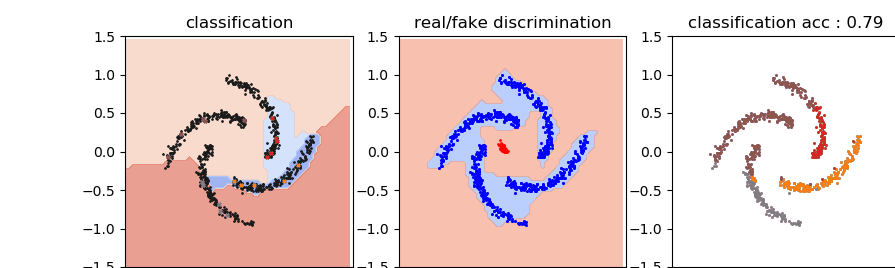

KeyboardInterrupt: 

In [25]:
tf.reset_default_graph()
# sess = tf.InteractiveSession()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
ssgan = Model(sess, nb_epoch=1000, lr_g=0.0003, lr_d=0.03, print_frequency=1,nb_class=4,batch_size=100)

f, ax = plt.subplots(1,3, sharex=True)
f.set_size_inches(10,3)
f.subplots_adjust(hspace=0.5)
plt.ion()
f.show()
f.canvas.draw()

ssgan.train(f,ax,X,X_lab,y_lab,X,y)
f.close()